<a href="https://colab.research.google.com/github/XuZuoLizzie/Archived_Work/blob/main/Retina_Image_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retina Image Analysis

The goal is to make a nice retinopathy model by using a pretrained inception v3 as a base and retraining some modified final layers with attention.

**Method**: In this task, I selected the VGG16 model as the pre-trained model. I used the same attention layers. In order to do the comparison and evaluate the effect of attention layers, I created a sequential model that consists of the VGG 16 pretrained model, two dense layers, and a prediction layer. In the experiments, I used exactly the same training hyerparameters for the two model. As the dataset is too large to train in Google Colab, I randomly selected 2,000 images from the training set and split it into training and validation set. The training time for the attention model for 14 epochs took more than 8 hours. The no-attention model was trained for only 8 epochs as the training time exceeds the Colab limits.

**Result**: I compared the validation loss after 8 epochs, the attention model achieved a validation loss of 1.56, and the validation loss continued decreasing after that. The no-attention model achieved a validation loss of 1.60 and we see no further Improvement. The comparison on the results of the attention model and the no-attention model showed that the attention layer can capture and highlight the important parts of the images.

In [ ]:
%matplotlib inline

## Download from Kaggle

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xuzuout","key":"22d7ba4d6c0681012d57407a322cd78b"}'}

In [ ]:
# Let's make sure the kaggle.json file is present.
! ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Nov 15 01:57 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
! pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# List available datasets.
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-11-10 18:11:20          15542  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           9439  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4227  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3445  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
! kaggle datasets download -d zhizhid/dr-2000

 99% 1.88G/1.90G [00:12<00:00, 163MB/s]
100% 1.90G/1.90G [00:13<00:00, 157MB/s]


In [ ]:
# Unzip data.
! unzip dr-2000.zip

Archive:  dr-2000.zip
  inflating: data/dr/10017_left.jpeg  
  inflating: data/dr/10017_right.jpeg  
  inflating: data/dr/1002_left.jpeg  
  inflating: data/dr/1002_right.jpeg  
  inflating: data/dr/10030_left.jpeg  
  inflating: data/dr/10030_right.jpeg  
  inflating: data/dr/10043_left.jpeg  
  inflating: data/dr/10043_right.jpeg  
  inflating: data/dr/10047_left.jpeg  
  inflating: data/dr/10047_right.jpeg  
  inflating: data/dr/10085_left.jpeg  
  inflating: data/dr/10085_right.jpeg  
  inflating: data/dr/1008_left.jpeg  
  inflating: data/dr/1008_right.jpeg  
  inflating: data/dr/10109_left.jpeg  
  inflating: data/dr/10109_right.jpeg  
  inflating: data/dr/10112_left.jpeg  
  inflating: data/dr/10120_left.jpeg  
  inflating: data/dr/10120_right.jpeg  
  inflating: data/dr/10125_left.jpeg  
  inflating: data/dr/10125_right.jpeg  
  inflating: data/dr/10131_left.jpeg  
  inflating: data/dr/10131_right.jpeg  
  inflating: data/dr/10135_left.jpeg  
  inflating: data/dr/10135_right.jp

In [ ]:
! cp -r '/content/data/dr/.' '/content/train/'
! cp -r '/content/data/normal/.' '/content/train/'

## Load data

In [ ]:
! pip install tensorflow==1.14.0

     |████████████████████████████████| 109.3 MB 25 kB/s 
     |████████████████████████████████| 488 kB 71.2 MB/s 
     |████████████████████████████████| 3.1 MB 85.6 MB/s 
     |████████████████████████████████| 50 kB 8.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob

In [ ]:
# Upload the label list.
base_image_dir = '/content/train'
retina_df = pd.read_csv('/content/trainLabels.csv')

In [ ]:
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

2000 images found of 35126 total


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

,image,level,PatientId,path,exists,eye,level_cat
9977,12587_right,2,12587,/content/train/12587_right.jpeg,True,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"
8654,10864_left,0,10864,/content/train/10864_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
8950,11229_left,0,11229,/content/train/11229_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


## Split data

In [ ]:
from sklearn.model_selection import train_test_split

rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'],
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 1563 validation 547


## Balance the distribution in the training set

New Data Size: 750 Old Size: 1563


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff228d1d490>,
      dtype=object)

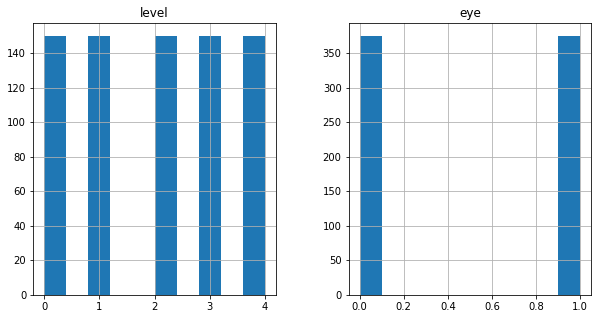

In [ ]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)

print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size,
                      horizontal_flip = True,
                      vertical_flip = False,
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch:
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y
        return _all_func

def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True,
                  vertical_flip = False,
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):

    load_ops = tf_image_loader(out_size = intermediate_size,
                               horizontal_flip=horizontal_flip,
                               vertical_flip=vertical_flip,
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [ ]:
def flow_from_dataframe(idg,
                        in_df,
                        path_col,
                        y_col,
                        shuffle = True,
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values,
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset

        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            yield K.get_session().run(next_batch)

In [ ]:
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE,
                        color_mode = 'rgb',
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size)
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb',
                         crop_probability=0.0,
                         horizontal_flip = False,
                         vertical_flip = False,
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df,
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df,
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


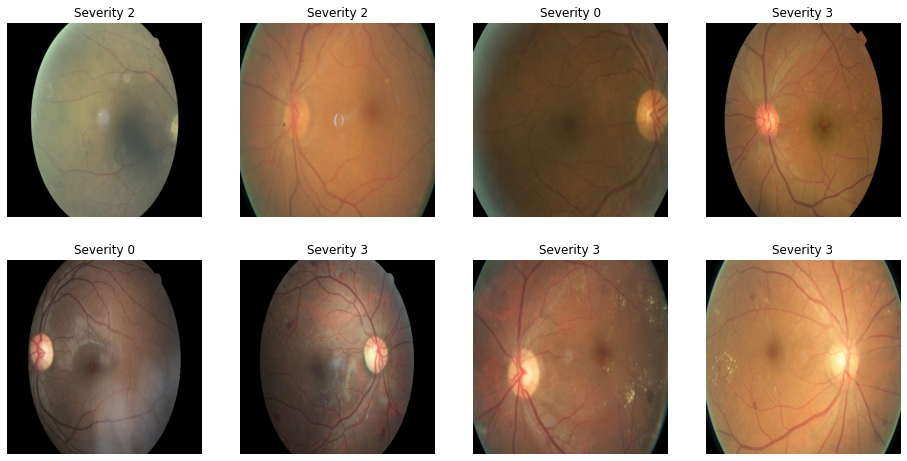

In [ ]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



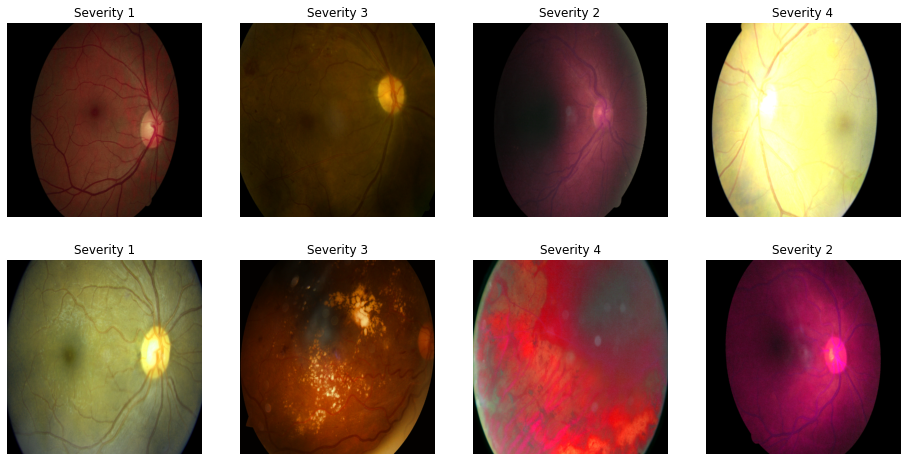

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

## Attention model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 as PTModel
# from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
# from keras.applications.inception_v3 import InceptionV3 as PTModel
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from tensorflow.keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from tensorflow.keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1,
                    kernel_size = (1,1),
                    padding = 'valid',
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same',
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from tensorflow.keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 16, 16, 512)  14714688    input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 512)  2048        vgg16[1][0]                      
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 16, 16, 512)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
! rm -rf ~/.keras # clean up before starting training

In [ ]:
retina_model.fit_generator(train_gen,
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen,
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = 25,
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False,
                             max_queue_size = 0
                            )

Epoch 1/25
14/15 [===========================>..] - ETA: 1:07 - loss: 1.6013 - categorical_accuracy: 0.2277 - top_2_accuracy: 0.4375
Epoch 00001: val_loss improved from inf to 1.72263, saving model to retina_weights.best.hdf5
15/15 [==============================] - 1682s 112s/step - loss: 1.6031 - categorical_accuracy: 0.2251 - top_2_accuracy: 0.4373 - val_loss: 1.7226 - val_categorical_accuracy: 0.0601 - val_top_2_accuracy: 0.1283
Epoch 2/25
14/15 [===========================>..] - ETA: 1:08 - loss: 1.5212 - categorical_accuracy: 0.3348 - top_2_accuracy: 0.5506
Epoch 00002: val_loss did not improve from 1.72263
15/15 [==============================] - 1765s 118s/step - loss: 1.5212 - categorical_accuracy: 0.3306 - top_2_accuracy: 0.5486 - val_loss: 1.7510 - val_categorical_accuracy: 0.0455 - val_top_2_accuracy: 0.1004
Epoch 3/25
14/15 [===========================>..] - ETA: 1:06 - loss: 1.4783 - categorical_accuracy: 0.3318 - top_2_accuracy: 0.5627
Epoch 00003: val_loss did not impro

## Without attention

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 as PTModel
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Flatten, Dropout
from tensorflow.keras.models import Model

base_model = PTModel(weights = None, include_top=False, input_shape=(512, 512, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(t_y.shape[-1], activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('no_attention')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
! rm -rf ~/.keras # clean up before starting training

In [ ]:
model.fit_generator(train_gen,
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen,
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = 25,
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False,
                             max_queue_size = 0
                            )

Epoch 1/25
14/15 [===========================>..] - ETA: 2:55 - loss: 1.6255 - categorical_accuracy: 0.1801 - top_2_accuracy: 0.3750
Epoch 00001: val_loss improved from inf to 1.60816, saving model to no_attention_weights.best.hdf5
15/15 [==============================] - 3088s 206s/step - loss: 1.6245 - categorical_accuracy: 0.1781 - top_2_accuracy: 0.3704 - val_loss: 1.6082 - val_categorical_accuracy: 0.2946 - val_top_2_accuracy: 0.3427
Epoch 2/25
14/15 [===========================>..] - ETA: 2:57 - loss: 1.6093 - categorical_accuracy: 0.1994 - top_2_accuracy: 0.4048
Epoch 00002: val_loss improved from 1.60816 to 1.60723, saving model to no_attention_weights.best.hdf5
15/15 [==============================] - 3220s 215s/step - loss: 1.6093 - categorical_accuracy: 0.2000 - top_2_accuracy: 0.4069 - val_loss: 1.6072 - val_categorical_accuracy: 0.0398 - val_top_2_accuracy: 0.3409
Epoch 3/25
14/15 [===========================>..] - ETA: 2:51 - loss: 1.6099 - categorical_accuracy: 0.1972 - 